In [1]:
%load_ext autotime

In [2]:
import pandas as pd
import numpy as np

from glob import glob
from astropy.io import fits
from astropy.stats import sigma_clipped_stats, sigma_clip
from astropy.nddata import Cutout2D

from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy import fftpack
from matplotlib.colors import LogNorm

from piaa.utils import helpers

time: 1.37 s


/home/wtgee/anaconda3/envs/panoptes/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
rgb_masks = np.load('/var/panoptes/rgb_masks.npz')
r_mask = rgb_masks['r']
g_mask = rgb_masks['g']
c_mask = rgb_masks['c']
b_mask = rgb_masks['b']

time: 330 ms


## Make Master Flat

In [4]:
flat_files = sorted(glob('/var/panoptes/images/flats/14d3bd/**/*.fits.fz'))

time: 2.66 ms


In [5]:
len(flat_files)

17

time: 5.75 ms


In [6]:
bias = 2047
min_level = 1000
saturation_level = 11000
desired_percentage = 0.5

time: 1.71 ms


In [7]:
desired_count = (saturation_level + min_level) * desired_percentage
print("Desired count: ", desired_count)

Desired count:  6000.0
time: 3.06 ms


In [8]:
center_position = (int(3476/2), int(5208/2))

time: 2.46 ms


In [9]:
r_region = Cutout2D(r_mask, center_position, 1000).data
g_region = Cutout2D(g_mask, center_position, 1000).data
c_region = Cutout2D(c_mask, center_position, 1000).data
b_region = Cutout2D(b_mask, center_position, 1000).data

time: 13 ms


In [10]:
enough_counts_fractional_error = 0.0125
fraction_saturated_pixels_limit = 0.05

time: 2.39 ms


In [11]:
def inv_median_center(data, stats_region=0.3, xaxis_number=1, yaxis_number=0):
    """
    Compute 1/median for scaling the flat field data using only a limited central region
    specified by stats_region parameter.
    """

    try:
        h = data.shape[0]
        w = data.shape[1]
    except IndexError:
        h = w = int(np.sqrt(data.shape[0]))
        data = data.reshape(h, w)
        
    center_xy = (int(h/2), int(w/2))
    size = (w*stats_region, h*stats_region)
    
    d0 = Cutout2D(data, center_xy, size)

    return 1. / np.median(d0.data)

time: 12.7 ms


In [12]:
flat_data = None

num_flats = 0

master_flat_data = list()
master_flat_weights = list()
flat_fn = list()
exp_times = list()

for f in flat_files:
    with fits.open(f) as hdul:
#         print()
        if f.endswith('.fits'):
            hdu = hdul[0]
        elif f.endswith('.fz'):
            hdu = hdul[1]

        exp_time = float(hdu.header['EXPTIME'])
        # Skip flats under 3 seconds (kind of empirical)
        if exp_time < 3:
            continue            
            
        # Get data and remove bias
        d0 = hdu.data - bias
        
        # Get center region
        c0 = Cutout2D(d0, center_position, 1000)
        
        mean, median, std = sigma_clipped_stats(c0.data)

        median_counts = np.median(c0.data)
        frac_saturated = np.sum(c0.data >= saturation_level) / (c0.data.shape[1] * c0.data.shape[0])

#         print("Median:   ", median_counts)
#         print("FEC        {:.02%}".format(np.sqrt(median_counts) / median_counts))
#         print("Saturated: {:.0%}".format(frac_saturated))
        
        # Figure out if within acceptables counts
        if (np.sqrt(median_counts) / median_counts < enough_counts_fractional_error 
            and frac_saturated < fraction_saturated_pixels_limit):
            
            flat_fn.append(f)
            exp_times.append(exp_time)

            print("Using Flat: {:5.02f}s μ={:.02f} σ={:.02f}".format(exp_time, mean, std))
            
            g_data = np.ma.array(d0, mask=np.logical_and(~g_mask, ~c_mask))
            master_flat_weights.append(inv_median_center(g_data))
            master_flat_data.append(d0)

Using Flat:  3.90s μ=6290.16 σ=2710.15


/home/wtgee/anaconda3/envs/panoptes/lib/python3.6/site-packages/numpy/core/fromnumeric.py:664: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Using Flat:  4.90s μ=6379.79 σ=2755.74
Using Flat:  5.90s μ=6166.67 σ=2670.32
Using Flat:  8.90s μ=6212.23 σ=2702.51
Using Flat: 10.90s μ=5980.84 σ=2610.34
Using Flat: 13.90s μ=5963.74 σ=2611.08
Using Flat: 17.90s μ=5954.41 σ=2614.54
Using Flat: 23.90s μ=6096.22 σ=2685.11
Using Flat: 31.90s μ=6129.25 σ=2709.63
Using Flat: 42.90s μ=6096.82 σ=2706.34
time: 9.65 s


In [13]:
"Good flats: {}".format(len(master_flat_data))

'Good flats: 10'

time: 2.58 ms


In [14]:
flat_data_file = '/var/panoptes/images/pan001-master_flat_data.npz'

time: 6.61 ms


In [16]:
# Save the file
np.savez_compressed(flat_data_file, *master_flat_data)

time: 38.9 s


In [17]:
ls -lh $flat_data_file

-rw-r--r-- 1 wtgee wtgee 280M Sep  4 20:03 /var/panoptes/images/pan001-master_flat_data.npz
time: 147 ms


In [11]:
# Or load the file
master_flat_npz = np.load(flat_data_file)

time: 7.35 ms


In [12]:
master_flat_data = [master_flat_npz[f] for f in master_flat_npz.files]

time: 11 s


#### Gain

Do a simple gain check

In [34]:
# Quick gain 
flat0 = sigma_clip(master_flat_data[0].astype(np.float), iters=2)
flat1 = sigma_clip(master_flat_data[1].astype(np.float), iters=2)

gain = (flat0 + flat1).mean() / (flat0 - flat1).std()**2
print("Gain is {:.02f} e-/ADU".format(gain))

Gain is 1.49 e-/ADU
time: 12.9 s


#### Combine flats

In [19]:
# Combine all the flats
median_flat = np.median(master_flat_data, axis=0)

time: 2.46 s


In [20]:
median_flat.shape

(3476, 5208)

time: 2.73 ms


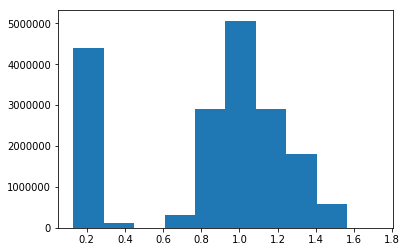

time: 457 ms


In [15]:
# Histogram of pixels
n, bins, patches = plt.hist(median_flat.flatten())

### Plot flat fields and FFT

In [14]:
fig = Figure()
fft_fig = Figure()
FigureCanvas(fig)
FigureCanvas(fft_fig)

ax = fig.add_subplot(111)
ax2 = fft_fig.add_subplot(111)

im = ax.imshow(median_flat)
ax.set_title('Master Flat')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(im, cax=cax)

# FFT
f0 = fftpack.fft2(median_flat)
ax2.imshow(np.abs(f0), cmap='Greys', norm=LogNorm())
ax2.set_title('Master Flat FFT')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])

fig.tight_layout()
fig.set_size_inches(fig.get_size_inches() * 4)
fig.savefig('/var/panoptes/images/pan001-master-flat-01.png', transparent=False)

fft_fig.tight_layout()
fft_fig.set_size_inches(fig.get_size_inches() * 4)
fft_fig.savefig('/var/panoptes/images/pan001-master-flat-01-fft.png', transparent=False)

time: 17.8 s


In [15]:
flat_fits = '/var/panoptes/images/pan001-master-flat.fits'

time: 1.22 ms


In [16]:
hdu = fits.PrimaryHDU(median_flat.astype(np.float32))
hdul = fits.HDUList([hdu])
hdul.writeto(flat_fits, overwrite=True)

time: 128 ms


## Examine Master Flat

In [4]:
# Load the master flat
flat_map = fits.getdata('/var/panoptes/images/pan001-master-flat.fits')

time: 23.1 ms


In [5]:
for color, mask in zip(['Reds', 'Greens', 'Greens2', 'Blues'], [r_mask, g_mask, c_mask, b_mask]):
    fig = Figure()
    fft_fig = Figure()
    
    FigureCanvas(fig)
    FigureCanvas(fft_fig)
    
    ax = fig.add_subplot(111)
    ax2 = fft_fig.add_subplot(111)

    d0 = np.ma.array(flat_map, mask=~mask)

    width = int(5208/2)    
    height = int(3476/2)
    
    cm = color
    if color is 'Greens2':
        cm = 'Greens'
    
    d0 = d0.compressed().reshape(height, width)
        
    # Show the flat
    im = ax.imshow(d0, cmap=cm)
    ax.set_title(color)
    
    # Colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    
    # Show the FFT
    f0 = fftpack.fft2(d0.astype(np.float))
    
    ax2.imshow(np.abs(f0), cmap='Greys_r', norm=LogNorm(vmin=5))
    ax2.set_title('{} FFT'.format(color))

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])    
    
    fig.tight_layout()
    fft_fig.tight_layout()
    
    fig.set_size_inches(fig.get_size_inches() * 2)
    fft_fig.set_size_inches(fft_fig.get_size_inches() * 2)
    
    fig.savefig('/var/panoptes/images/pan001-master-flat-channel-{}.png'.format(color))
    fft_fig.savefig('/var/panoptes/images/pan001-master-flat-channel-{}-fft.png'.format(color))

time: 7.25 s


In [6]:
fig = Figure()
fft_fig = Figure()

FigureCanvas(fig)
FigureCanvas(fft_fig)

ax =  fig.add_subplot(111)
ax2 =  fft_fig.add_subplot(111)

# Show the flat
im = ax.imshow(flat_map, cmap='Greys', norm=LogNorm())
ax.set_title('Master Flat')

# Colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)

# Show the FFT
f0 = fftpack.fft2(flat_map.astype(np.float))

ax2.imshow(np.abs(f0), cmap='Greys_r', norm=LogNorm(vmin=5))
ax2.set_title('FFT')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])

fig.tight_layout()
fig.set_size_inches(fig.get_size_inches() * 2)
fig.savefig('/var/panoptes/images/pan001-master-flat-02.png', transparent=False)

fft_fig.tight_layout()
fft_fig.set_size_inches(fig.get_size_inches() * 2)
fft_fig.savefig('/var/panoptes/images/pan001-master-flat-02-fft.png', transparent=False)

time: 6.19 s
